# Policy iteration and value iteration

In this notebook, you will implement different dynamic programming approaches described in [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). A grid ```World``` class and policy iteration has been implemented. Feel free to add more actions, rewards and/or terminals, or to modify the code to suit your needs.

### Install dependencies

In [2]:
! pip install numpy pandas

! pip install PyQt6

### Imports

In [3]:
import numpy as np
import sys          # We use sys to get the max value of a float
import pandas as pd # We only use pandas for displaying tables nicely
pd.options.display.float_format = '{:,.3f}'.format
import matplotlib.pyplot as plt
import time
import os

In [ ]:

# Globals:
ACTIONS = ("up", "down", "left", "right")

# Rewards, terminals and obstacles are characters:
REWARDS = {" ": -0.1, ".": 100, "+": 10, "-": -10}
TERMINALS = ("+", "-") # Note a terminal should also have a reward assigned
OBSTACLES = ("#")
WORLD_SIZE = 10

# Discount factor
gamma = 0.9


# The probability of a random move:
rand_move_probability = 0

#Tempreture parameter (for Boltzmann policy) [high beta is greedy low is exploration]
beta = 0.9
alpha = 0.1

#numbers of drones to simulate
number_of_agents = 2

drones = []


class World:
  def __init__(self, width, height):
    self.width = width
    self.height = height
    # Create an empty world where the agent can move to all cells
    self.grid = np.full((width, height), ' ', dtype='U1')

  def add_obstacle(self, start_x, start_y, end_x=None, end_y=None):
    """
    Create an obstacle in either a single cell or rectangle.
    """
    if end_x == None: end_x = start_x
    if end_y == None: end_y = start_y

    self.grid[start_x:end_x + 1, start_y:end_y + 1] = OBSTACLES[0]

  def add_reward(self, x, y, reward):
    assert reward in REWARDS, f"{reward} not in {REWARDS}"
    self.grid[x, y] = reward

  def add_terminal(self, x, y, terminal):
    assert terminal in TERMINALS, f"{terminal} not in {TERMINALS}"
    self.grid[x, y] = terminal

  def is_obstacle(self, x, y):
    if x < 0 or x >= self.width or y < 0 or y >= self.height:
      return True
    else:
      return self.grid[x ,y] in OBSTACLES

  def is_terminal(self, x, y):
    return self.grid[x ,y] in TERMINALS

  def get_reward(self, x, y):
    """
    Return the reward associated with a given location
    """
    return REWARDS[self.grid[x, y]]

  def get_next_state(self, current_state, action, deterministic=False):
    """
    Get the next state given a current state and an action. Can eiter be
    deterministic (no random actions) or non-deterministic,
    where rand_move_probability determines the probability of ignoring the
    action and performing a random move.
    """
    x,y = current_state
    if action == "up":      y -= 1
    elif action == "down":  y += 1
    elif action == "left":  x -= 1
    elif action == "right": x += 1

    # If the next state is an obstacle, stay in the current state
    next_state = (x, y) if not self.is_obstacle(x, y) else current_state
    return next_state

  def get_state_transition_probabilities(self, current_state, action):
    """
    Returns a dict where key = state and value = probability given current state
    is (x,y) and "action" is performed.
    """
    assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

    x, y = current_state
    if self.is_terminal(x, y):
      return {}

    next_state_probabilities = {}
    # Since there is rand_move_probability of performing any action, we have to
    # go through all actions and check what their next state would be:
    for a in ACTIONS:
      next_state = self.get_next_state((x, y), a, deterministic=True)
      if a == action:
        prob = 1 - rand_move_probability + rand_move_probability / len(ACTIONS)
      else:
        prob = rand_move_probability / len(ACTIONS)
Q = np.full((world.width,world.height,4),0.0)Q = np.full((world.width,world.height,4),0.0)
        next_state_probabilities[next_state] += prob
      else:
        if prob > 0.0:
          next_state_probabilities[next_state] = prob

    return next_state_probabilities
  

# Drone class


In [5]:
import numpy as np
import os

class Drone:
    def __init__(self, drone_id, world, start_state=None, q_table_file="q_table.npy"):
        self.id = drone_id
        self.world = world
        self.q_table_file = q_table_file
        self.Q = self.load_or_initialize_q_table()
        self.state = (0,0)
        self.beta = 0.9  # Define beta for softmax
        self.path = []

        # Ensure starting state is not an obstacle
        while self.world.is_obstacle(*self.state):
            self.state = (np.random.randint(0, world.width), np.random.randint(0, world.height))
        
        self.cumulative_reward = 0  # Track total collected rewards
        self.visited_states = [self.state]  # Track visited states
        self.active = True  # Drone status
    
    def pathReset(self):
        self.path = []
    
    def swarm_softmax_policy(self, Q):
        """ Select an action using softmax over rewards """
        q_values = Q[self.state]
        exp_q = np.exp(self.beta * q_values)
        probabilities = exp_q / np.sum(exp_q)
        return ACTIONS[np.random.choice(len(ACTIONS), p=probabilities)]
    
    def load_or_initialize_q_table(self):
        """ Check if Q-table file exists, load it, otherwise initialize a new Q-table. """
        if os.path.exists(self.q_table_file):
            return np.load(self.q_table_file)
        else:
            return np.random.rand(self.world.width, self.world.height, len(ACTIONS))


    def swarm_reward(self, Q):
        """ Compute reward with cooperative strategy """
        current_action = self.swarm_softmax_policy(Q)

        next_state = self.world.get_next_state(self.state, current_action)
        

        # Compute cooperative reward
        reward_coop = sum(drone.compute_reward(self.world.get_next_state(drone.state, current_action)) 
                          for drone in drones) / number_of_agents
        
        reward = alpha * self.world.get_reward(next_state[0], next_state[1]) + (1 - alpha) * reward_coop
        return reward

    def compute_reward(self, state):
        """ Compute the reward for a given state """
        return self.world.get_reward(*state)

    
    def plotPath(self):
        """ Plot the path taken by the drone """
        path = np.array(self.path)
        print(f"Drone {self.id} path:")
        plt.plot(path[:, 0], path[:, 1], label=f"Drone {self.id}")
        plt.scatter(path[:, 0], path[:, 1])
        plt.xlim(0, max(1, path[:, 0].max()))  # Ensuring at least 1 so it's visible
        plt.ylim(0, max(1, path[:, 1].max()))
        plt.xticks(np.arange(0, self.world.width + 1, 1))  # Step size of 1
        plt.yticks(np.arange(0, self.world.height + 1, 1))  # Step size of 1
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.legend()
        plt.grid(True)
        plt.show()


# laver world og agents


In [6]:
world = World(WORLD_SIZE, WORLD_SIZE)

# Add obstacles
world.add_obstacle(1, 1, 3, 3)
world.add_reward(2, 6, ".")
world.add_reward(5, 2, ".")
world.add_reward(2, 8, ".")
world.add_reward(1, 2, ".")
world.add_reward(9, 9, ".")
world.add_reward(8, 7, ".")
world.add_reward(2, 6, ".")


# Note, that we have to transpose the 2D array (.T) for (x,y)
# to match the convention when displayed
print(world.grid.T)
for i in range(number_of_agents):  # Use a range to generate the desired number of drones
    new_drone = Drone(i, world)  # Create a new Drone object
    drones.append(new_drone) 


Q = np.random.rand(world.width, world.height, len(ACTIONS))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' '#' '#' '#' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' '.' '#' '#' ' ' '.' ' ' ' ' ' ' ' ']
 [' ' '#' '#' '#' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' '.' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '.' ' ']
 [' ' ' ' '.' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '.']]


# Policy og action selection

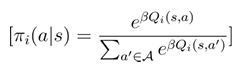 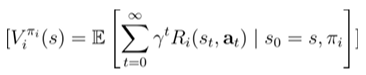 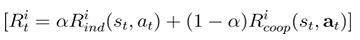

## Iterative policy evaluation


Iterative policy evaluation takes a ```World```, a discount factor, $\gamma$ (```gamma```, defined above in the ```World``` code cell), a policy, $\pi$, and a threshold, $\theta$ (```theta```), that determines when to stop the iteration. You can also specify a maximum number of iterations which can be useful for debugging using the ```max_iterations``` argument.

**IMPORTANT:** Remember that in iterative policy evaluation, we just learn state values ($V_\pi$) given a policy $\pi$. We are **not** trying to learn a policy.

(see page 74-75 of [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) for an explanation and the algorithm)

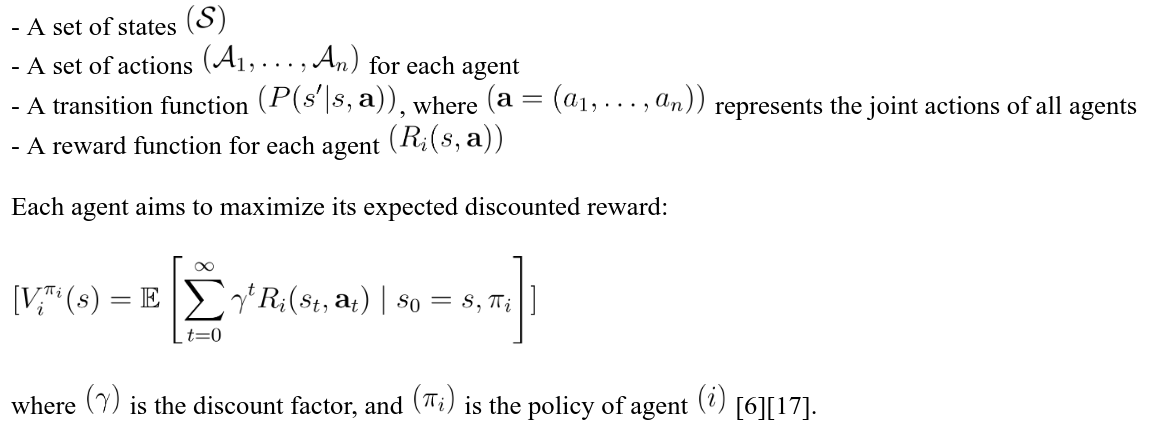

0 1
2 0
3 0
4 0
4 1
5 1
6 1
7 1
9 0
9 0
0 1
5 1
6 1
6 2
8 1
8 2
9 2
0 1
1 2
5 2
5 3
6 1
7 1
8 3
9 3
0 3
5 3
5 4
7 3
8 3
9 3
9 4
0 5
2 4
2 4
3 5
3 4
5 3
5 4
8 4
8 5
9 4
1 5
2 5
3 5
3 6
4 6
5 4
6 6
8 5
9 5
9 6
0 5
1 7
1 6
4 6
4 7
6 6
6 5
6 6
8 7
9 6
0 7
1 6
2 8
3 8
5 7
5 8
7 7
7 8
9 7
9 8
1 8
1 7
2 7
3 7
5 8
4 8
7 8
7 9
8 9
9 9
0 9
1 8
3 9
4 9
4 9
5 9
6 8
7 9
8 9
9 9
0 1
2 0
2 0
3 0
4 1
5 0
6 0
6 0
8 0
8 0
0 2
4 2
5 0
6 0
6 1
8 2
9 1
0 2
0 2
4 1
6 2
6 3
8 2
9 2
9 1
0 2
4 2
5 4
6 4
7 2
9 3
8 3
0 3
0 4
2 5
3 4
5 4
5 3
6 3
7 3
8 3
9 4
1 5
2 5
1 5
4 5
4 4
4 5
6 4
6 5
7 5
9 5
1 6
0 6
1 6
4 6
3 6
5 7
7 6
7 5
7 6
9 5
1 7
1 8
2 6
3 8
5 7
5 6
7 7
7 8
8 6
9 7
0 8
1 9
1 8
2 8
5 8
4 8
5 8
8 8
8 7
9 7
0 9
1 8
2 9
4 9
3 9
6 9
6 8
8 9
9 9
8 9
0 1
1 0
2 0
3 0
4 1
5 1
7 0
6 0
8 1
9 0
0 1
5 1
5 0
5 1
7 2
9 1
9 0
0 1
1 2
5 2
5 3
7 2
6 2
9 2
9 3
0 3
4 2
5 4
6 4
7 4
9 3
9 3
1 4
1 5
2 4
2 4
5 4
5 3
6 3
6 4
9 4
9 3
0 6
1 6
1 5
4 5
5 5
6 5
6 6
8 5
9 5
8 5
0 5
2 6
2 7
3 7
4 7
5 7
6 7
7 7
7 6
9 7
0 8
1 8
3 7
3 8


,0,1,2,3,4,5,6,7,8,9
0,down,left,up,down,left,down,up,up,left,right
1,up,down,up,right,down,up,right,up,up,right
2,up,left,left,down,down,down,left,down,down,up
3,up,right,right,right,left,down,down,right,left,right
4,down,up,left,up,left,right,left,left,right,left
5,down,down,right,down,left,left,right,down,down,left
6,right,left,down,right,right,down,left,left,up,left
7,right,up,right,up,up,left,down,left,right,right
8,right,left,right,right,down,up,left,left,down,left
9,left,down,down,up,left,down,right,left,down,left


Drone 2's Action Table:


,0,1,2,3,4,5,6,7,8,9
0,up,left,down,up,up,up,down,left,down,left
1,right,right,up,down,up,left,up,down,down,down
2,down,down,right,up,left,left,right,left,down,down
3,down,left,down,down,left,right,up,down,right,right
4,up,down,right,down,left,up,down,right,right,left
5,right,left,up,right,left,left,up,left,up,right
6,up,right,up,down,down,up,down,down,up,right
7,left,up,left,down,up,up,right,left,left,up
8,up,right,up,left,up,up,up,right,up,right
9,up,up,right,up,down,right,up,down,up,up


Drone 0 path:


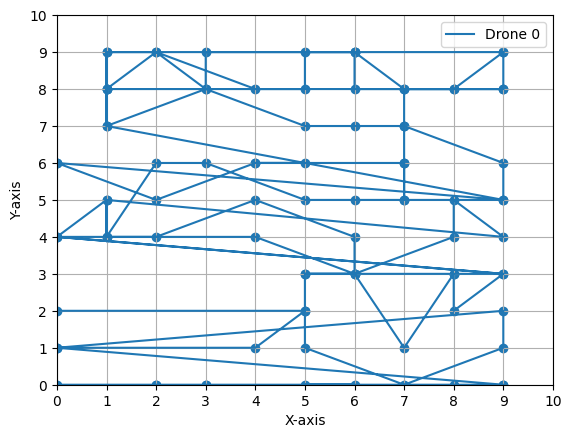

In [7]:
import numpy as np

import numpy as np

def iterative_policy_evaluation(world, drones, theta=1e-5, max_iterations=1000):
    """
    Perform iterative policy evaluation using a Boltzmann policy for multiple drones.

    Args:
        world: The environment providing state transitions and rewards.
        drones: List of drone agents in the environment.
        gamma: Discount factor for future rewards.
        theta: Convergence threshold.
        max_iterations: Maximum number of iterations.

    Returns:
        V: Estimated state-value function (width x height).
    """
    
    # Initialize state-value function V(s) for all states
    V = np.zeros((world.width, world.height))
    
    for _ in range(max_iterations):
        delta = 0  # Track the largest change in state-values
        for drone in drones:
            drone.pathReset()
            
            # Iterate over all states in the environment
            for y in range(world.height):
                for x in range(world.width):
                    if world.is_obstacle(x, y):
                        continue  # Skip obstacles
                    
                    # Get the action chosen by the policy
                    action = drone.swarm_softmax_policy(drone.Q)
                    
                    # Compute expected value for V(x, y)
                    v_new = 0
                   
                    next_x, next_y = world.get_next_state((x, y), action)
                    print(next_x, next_y)
                    drone.path.append((next_x, next_y))  # Track visited states
                    reward = drone.swarm_reward(drone.Q)  # Compute reward using drone's function

                    
                    # Bellman expectation equation for policy evaluation
                    v_new += reward + gamma * V[next_x, next_y]
                    
                        
                    
                    # Track the max change in values (for convergence check)
                    delta = max(delta, abs(v_new - V[x, y]))
                    V[x, y] = v_new  # Update state-value estimate
        
        # Check convergence
        if delta < theta:
            break
    return V  # Return state-value function


V = iterative_policy_evaluation(world, drones)


#store the action tables for each drone in a table and print each table
Q_best_table = []

for i in range(number_of_agents):  # Separate table for each drone
    Q_best = np.full((world.width, world.height), "               ")  # Initialize per drone
    
    for w in range(world.width):
        for h in range(world.height):
            Q_best[w, h] = ACTIONS[np.argmax(drones[i].Q[w, h, :])]  # Store best action

    Q_best_table.append(Q_best.copy())  # Store a COPY, not a reference

# Display individual tables
for i in range(number_of_agents):
    print(f"Drone {i+1}'s Action Table:")
    display(pd.DataFrame(Q_best_table[i].T))



#plot drone path (lav et for loop til at printe hver drones path)
drones[0].plotPath()



## Implementation of Example 4.1 from the book

Below, you can see the implementation of Example 4.1 on page 76 in the book [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)

In [8]:
# World is 4x4
world = World(4, 4)

# Rewards are -1 for each move (including when hitting a terminal state, "+"):
REWARDS = {" ": -1, "+": -1}


# Add terminal states in two corners
world.add_terminal(0, 0, "+")
world.add_terminal(3, 3, "+")

print(world.grid.T)

[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]


## Exercise - policy iteration

You are now ready to implement policy iteration. That is, first estimate state values under a given policy, then improve the policy based on those estimates and action values, estimate state values again, and so on. See page 80 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)

You will need an explicit representation of your policy that you can easily change.

Test your implementation and print out the policies found.


In [9]:
# TODO: Implement your code here

rand_move_probability = 0.5
gamma = 0.8

MatPol = np.full((4,4), 'right')

def explicit_policy(x,y):
    return {MatPol [x,y] : 1}


def policy_iteration(world, policy):
    
    while(True):
        policy_stable = True
        V = iterative_policy_evaluation(world, explicit_policy)
        
        for x in range(world.width):
            for y in range(world.height):
                old_action = policy[x,y]

                for action in ACTIONS:
                    
                    if action_value(world, V, (x,y), action) > action_value(world, V, (x,y), old_action):
                        policy[x,y] = action
                if (old_action != policy[x,y]):
                    policy_stable = False
        if policy_stable:
            display(pd.DataFrame(V.T))
            display(pd.DataFrame(policy.T))
            display(pd.DataFrame(world.grid.T))
            return
            
policy_iteration(world, MatPol)

TypeError: 'function' object is not iterable